 # Notebook 6: Discourse and Representation Features

 ## Purpose
 - Active vs passive voice detection
 - Agency and agent deletion analysis
 - Speaking role ratios (quotes attribution)
 - Decision-maker vs victim roles
 - Protagonist/antagonist counting
 - Expert source attribution

 ## Inputs
 - `data/processed/articles_with_events.csv`

 ## Outputs
 - `data/processed/discourse_features.parquet`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import nltk
from collections import Counter

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported")

Libraries imported


In [5]:
# Paths
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

INPUT_FILE = PROCESSED_DIR / 'articles_with_events.csv'
OUTPUT_FILE = PROCESSED_DIR / 'discourse_features.parquet'

 ## 1. Load Data

In [6]:
print("Loading data...")
df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df):,} articles")

text_column = 'article_text' if 'article_text' in df.columns else 'text'
df['text_for_analysis'] = df[text_column].fillna('')

Loading data...
Loaded 49,926 articles


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_18804/248979150.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


 ## 2. Voice Detection (Active vs Passive)

In [7]:
print("\nDetecting active and passive voice...")

# Passive voice indicators
PASSIVE_INDICATORS = [
    r'\b(is|are|was|were|been|being)\s+\w+ed\b',  # be + past participle
    r'\b(is|are|was|were|been|being)\s+\w+en\b',  # be + irregular past participle
    r'\bwas\s+\w+ed\s+by\b',
    r'\bwere\s+\w+ed\s+by\b',
    r'\bhave\s+been\s+\w+ed\b',
    r'\bhas\s+been\s+\w+ed\b'
]


def count_passive_constructions(text):
    if not text:
        return 0
    count = 0
    text_lower = text.lower()
    for pattern in PASSIVE_INDICATORS:
        count += len(re.findall(pattern, text_lower))
    return count


df['passive_voice_count'] = df['text_for_analysis'].apply(count_passive_constructions)

# Calculate ratio (normalize by sentence count)
df['sentence_count_discourse'] = df['text_for_analysis'].str.count(r'[.!?]+').replace(0, 1)
df['passive_voice_ratio'] = df['passive_voice_count'] / df['sentence_count_discourse']

# Flag high passive voice usage
df['high_passive_voice'] = (df['passive_voice_ratio'] > 0.3).astype(int)

print("Voice detection complete")
print(f"  Articles with passive voice: {(df['passive_voice_count'] > 0).sum():,}")
print(f"  High passive voice articles: {df['high_passive_voice'].sum():,}")


Detecting active and passive voice...
Voice detection complete
  Articles with passive voice: 40,391
  High passive voice articles: 9,763


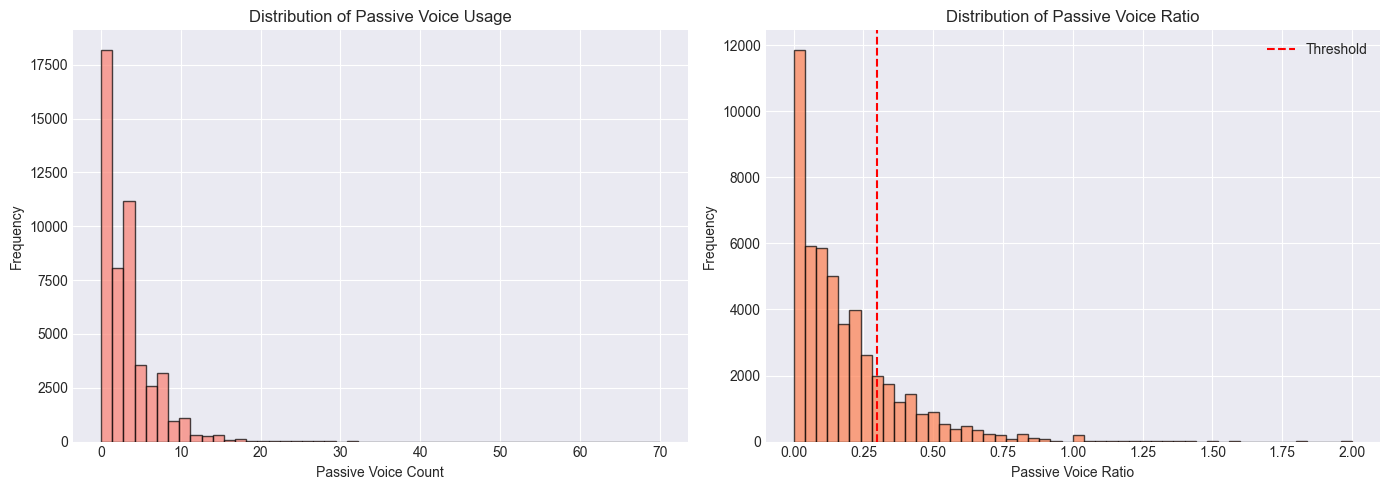

In [8]:
# Visualize passive voice
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Passive voice count distribution
df['passive_voice_count'].hist(bins=50, ax=axes[0], edgecolor='black', alpha=0.7, color='salmon')
axes[0].set_xlabel('Passive Voice Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Passive Voice Usage')

# Passive voice ratio
df['passive_voice_ratio'].hist(bins=50, ax=axes[1], edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Passive Voice Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Passive Voice Ratio')
axes[1].axvline(0.3, color='red', linestyle='--', label='Threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Key Insights: Passive Voice Usage

1) Most articles use little passive voice overall, with passive-voice counts heavily concentrated at low values and only a small number of articles showing very high counts.

2) Passive voice ratios are usually below the chosen threshold (~0.25), meaning only a minority of articles have a high share of passive constructions relative to their total text.

 ## 3. Agency and Agent Deletion

In [9]:
print("\nAnalyzing agency and agent deletion...")

# Agent deletion patterns (passive without 'by' phrase)
AGENT_DELETION_PATTERNS = [
    r'\b(is|are|was|were)\s+\w+ed\b(?!\s+by)',
    r'\bhave\s+been\s+\w+ed\b(?!\s+by)',
    r'\bhas\s+been\s+\w+ed\b(?!\s+by)'
]


def count_agent_deletion(text):
    if not text:
        return 0
    count = 0
    text_lower = text.lower()
    for pattern in AGENT_DELETION_PATTERNS:
        count += len(re.findall(pattern, text_lower))
    return count


df['agent_deletion_count'] = df['text_for_analysis'].apply(count_agent_deletion)
df['agent_deletion_ratio'] = df['agent_deletion_count'] / df['sentence_count_discourse']

# Agentless constructions
AGENTLESS_PATTERNS = [
    r'\bit\s+(is|was)\s+(said|reported|claimed|believed|thought)\b',
    r'\bthere\s+(is|are|was|were)\b',
    r'\bone\s+(can|could|should|must|may|might)\b'
]

df['agentless_count'] = df['text_for_analysis'].apply(
    lambda x: sum(len(re.findall(p, x.lower())) for p in AGENTLESS_PATTERNS) if x else 0
)

print("Agency analysis complete")
print(f"  Articles with agent deletion: {(df['agent_deletion_count'] > 0).sum():,}")
print(f"  Articles with agentless constructions: {(df['agentless_count'] > 0).sum():,}")


Analyzing agency and agent deletion...
Agency analysis complete
  Articles with agent deletion: 35,167
  Articles with agentless constructions: 14,129


 ## 4. Quote Attribution and Speaking Roles

In [10]:
print("\nAnalyzing quote attribution...")

# Quote patterns
QUOTE_PATTERNS = [
    r'["\']([^"\']+)["\']',  # Anything in quotes
    r'said\s+["\']',
    r'["\'].*?\bsaid\b',
    r'according\s+to\b'
]


def extract_quote_indicators(text):
    if not text:
        return {'quote_count': 0, 'attribution_count': 0, 'said_count': 0}

    text_lower = text.lower()

    # Count quotes
    quote_count = len(re.findall(r'["\'][^"\']+["\']', text))

    # Count attributions
    attribution_words = ['said', 'told', 'stated', 'claimed', 'argued', 'explained',
                         'remarked', 'noted', 'added', 'according to']
    attribution_count = sum(text_lower.count(word) for word in attribution_words)

    # Count 'said' specifically
    said_count = text_lower.count('said')

    return {
        'quote_count': quote_count,
        'attribution_count': attribution_count,
        'said_count': said_count
    }


quote_results = df['text_for_analysis'].apply(extract_quote_indicators)
df['quote_count'] = quote_results.apply(lambda x: x['quote_count'])
df['attribution_count'] = quote_results.apply(lambda x: x['attribution_count'])
df['said_count'] = quote_results.apply(lambda x: x['said_count'])

# Quote ratio
df['quote_ratio'] = df['quote_count'] / df['sentence_count_discourse']

# Attribution ratio (quotes with attribution)
df['attribution_ratio'] = np.where(
    df['quote_count'] > 0,
    df['attribution_count'] / df['quote_count'],
    0
)

print("Quote analysis complete")
print(f"  Articles with quotes: {(df['quote_count'] > 0).sum():,}")
print(f"  Avg quotes per article: {df['quote_count'].mean():.2f}")


Analyzing quote attribution...
Quote analysis complete
  Articles with quotes: 7,661
  Avg quotes per article: 0.74


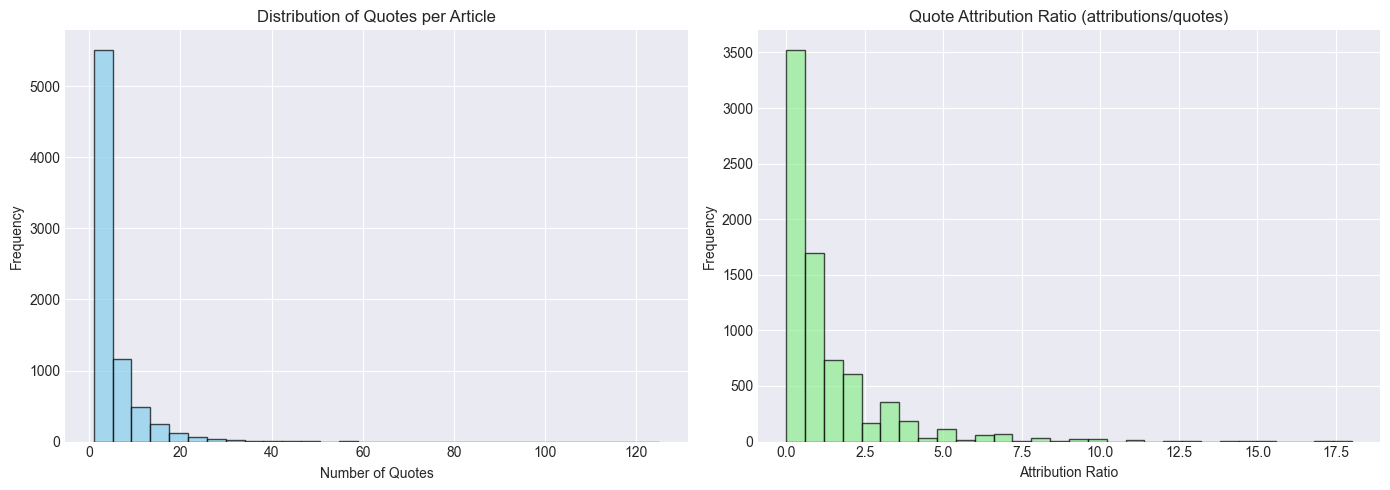

In [11]:
# Visualize quotes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Quote count distribution
df[df['quote_count'] > 0]['quote_count'].hist(bins=30, ax=axes[0],
                                              edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Number of Quotes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Quotes per Article')

# Attribution ratio
df[df['quote_count'] > 0]['attribution_ratio'].hist(bins=30, ax=axes[1],
                                                    edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_xlabel('Attribution Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Quote Attribution Ratio (attributions/quotes)')

plt.tight_layout()
plt.show()

#### Key Insights: Quotes and Attributions

1) Most articles use few direct quotes, with the distribution heavily skewed toward 0–5 quotes and only a small minority of stories containing many (dozens of) quotes.

2) Attribution intensity is usually modest but highly skewed, with many articles having low attribution ratios and a long tail of pieces where quotes are much more heavily attributed, indicating uneven use of explicit source attribution.

 ## 5. Role Analysis (Decision-maker vs Victim)

In [12]:
print("\nAnalyzing roles (decision-maker vs victim)...")

# Decision-maker indicators
DECISION_MAKER_TERMS = [
    'decided', 'announced', 'declared', 'ordered', 'commanded',
    'directed', 'instructed', 'implemented', 'launched', 'initiated',
    'minister', 'president', 'chief', 'director', 'official', 'authority'
]

# Victim/affected indicators
VICTIM_TERMS = [
    'victim', 'affected', 'suffered', 'injured', 'harmed', 'damaged',
    'displaced', 'lost', 'died', 'killed', 'wounded', 'hurt',
    'impacted negatively', 'consequences', 'casualties'
]


def count_role_terms(text, term_list):
    if not text:
        return 0
    text_lower = text.lower()
    count = 0
    for term in term_list:
        pattern = r'\b' + re.escape(term) + r'\b'
        count += len(re.findall(pattern, text_lower))
    return count


df['decision_maker_count'] = df['text_for_analysis'].apply(
    lambda x: count_role_terms(x, DECISION_MAKER_TERMS)
)
df['victim_count'] = df['text_for_analysis'].apply(
    lambda x: count_role_terms(x, VICTIM_TERMS)
)

# Role balance
df['decision_maker_ratio'] = df['decision_maker_count'] / (
    df['decision_maker_count'] + df['victim_count'] + 1
)

df['victim_ratio'] = df['victim_count'] / (
    df['decision_maker_count'] + df['victim_count'] + 1
)

# Dominant role
df['dominant_role'] = np.where(
    df['decision_maker_count'] > df['victim_count'],
    'decision_maker',
    np.where(df['victim_count'] > df['decision_maker_count'], 'victim', 'balanced')
)

print("Role analysis complete")
print(f"\nRole distribution:")
print(df['dominant_role'].value_counts())


Analyzing roles (decision-maker vs victim)...
Role analysis complete

Role distribution:
dominant_role
decision_maker    28048
balanced          15112
victim             6766
Name: count, dtype: int64


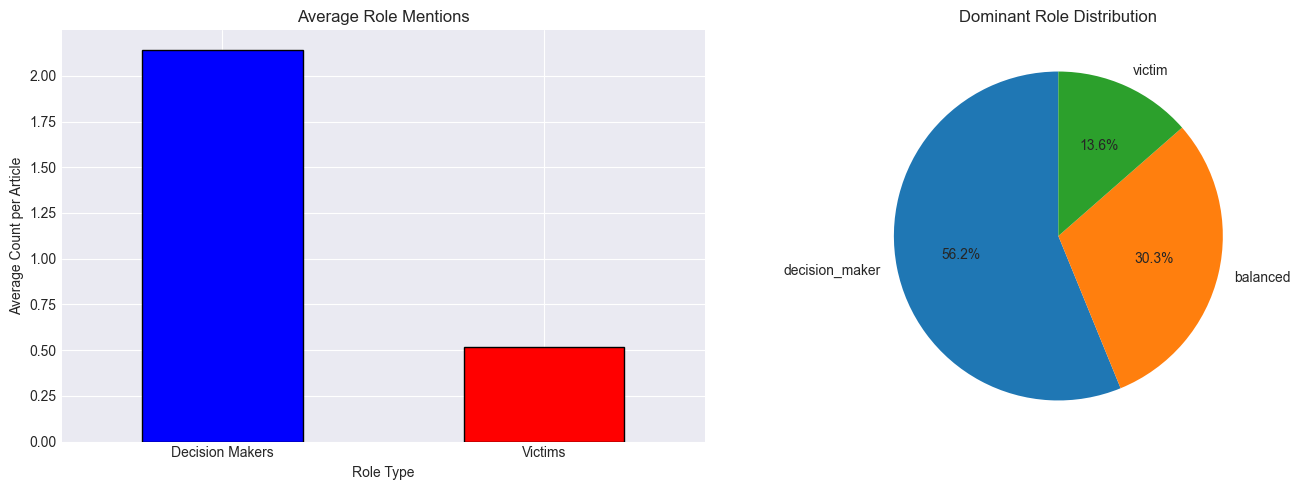

In [13]:
# Visualize roles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Role counts
role_data = pd.DataFrame({
    'Decision Makers': df['decision_maker_count'],
    'Victims': df['victim_count']
})
role_data.mean().plot(kind='bar', ax=axes[0], color=['blue', 'red'], edgecolor='black')
axes[0].set_xlabel('Role Type')
axes[0].set_ylabel('Average Count per Article')
axes[0].set_title('Average Role Mentions')
axes[0].tick_params(axis='x', rotation=0)

# Dominant role distribution
df['dominant_role'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_ylabel('')
axes[1].set_title('Dominant Role Distribution')

plt.tight_layout()
plt.show()

#### Key Insights: Role Representation in Coverage

1) Decision makers dominate the narrative, appearing on average about four times as often as victims in each article, indicating a strong focus on those in power.

2) Most articles are decision‑maker–centric, with over half having decision makers as the dominant role, only about 14% being victim‑centric, and roughly 30% offering a more balanced representation.

 ## 6. Protagonist vs Antagonist Framing

In [14]:
print("\nAnalyzing protagonist/antagonist framing...")

# Positive framing terms (protagonist)
PROTAGONIST_TERMS = [
    'hero', 'leader', 'champion', 'defender', 'protector', 'savior',
    'helped', 'saved', 'rescued', 'supported', 'assisted', 'aided',
    'successful', 'achieved', 'accomplished', 'won', 'prevailed'
]

# Negative framing terms (antagonist)
ANTAGONIST_TERMS = [
    'villain', 'criminal', 'terrorist', 'extremist', 'radical', 'militant',
    'accused', 'alleged', 'suspected', 'blamed', 'criticized', 'condemned',
    'failed', 'lost', 'defeated', 'guilty', 'wrong', 'bad'
]

df['protagonist_count'] = df['text_for_analysis'].apply(
    lambda x: count_role_terms(x, PROTAGONIST_TERMS)
)
df['antagonist_count'] = df['text_for_analysis'].apply(
    lambda x: count_role_terms(x, ANTAGONIST_TERMS)
)

# Framing balance
df['framing_balance'] = (df['protagonist_count'] - df['antagonist_count']) / (
    df['protagonist_count'] + df['antagonist_count'] + 1
)

# Dominant framing
df['dominant_framing'] = np.where(
    df['protagonist_count'] > df['antagonist_count'],
    'positive',
    np.where(df['antagonist_count'] > df['protagonist_count'], 'negative', 'neutral')
)

print("Framing analysis complete")
print(f"\nFraming distribution:")
print(df['dominant_framing'].value_counts())


Analyzing protagonist/antagonist framing...
Framing analysis complete

Framing distribution:
dominant_framing
neutral     25807
negative    13083
positive    11036
Name: count, dtype: int64


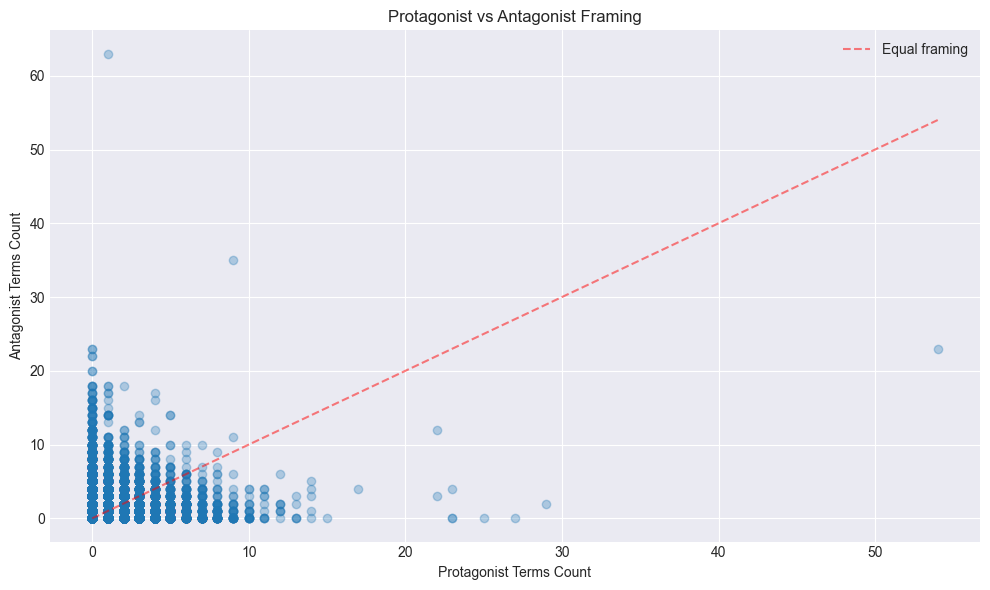

In [15]:
# Visualize framing
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(df['protagonist_count'], df['antagonist_count'], alpha=0.3)
ax.set_xlabel('Protagonist Terms Count')
ax.set_ylabel('Antagonist Terms Count')
ax.set_title('Protagonist vs Antagonist Framing')
ax.plot([0, df['protagonist_count'].max()], [0, df['protagonist_count'].max()],
        'r--', alpha=0.5, label='Equal framing')
ax.legend()
plt.tight_layout()
plt.show()

#### Key Insights: Protagonist vs Antagonist Framing

1) Most articles mention only a small number of framing terms, with both protagonist and antagonist counts clustered near the origin, indicating that heavy framing language is relatively rare.

2) Framing is often imbalanced rather than neutral: many points lie away from the equal‑framing line, showing articles where either antagonist terms dominate at low protagonist counts or, in fewer cases, protagonist terms greatly outnumber antagonist mentions.

 ## 7. Expert and Authority Attribution

In [16]:
print("\nAnalyzing expert and authority attribution...")

# Expert terms
EXPERT_TERMS = [
    'expert', 'specialist', 'professor', 'researcher', 'scientist',
    'analyst', 'scholar', 'doctor', 'phd', 'academic'
]

# Authority terms
AUTHORITY_TERMS = [
    'official', 'minister', 'secretary', 'commissioner', 'chief',
    'director', 'head', 'president', 'prime minister', 'governor',
    'police', 'court', 'judge', 'government'
]

df['expert_mention_count'] = df['text_for_analysis'].apply(
    lambda x: count_role_terms(x, EXPERT_TERMS)
)
df['authority_mention_count'] = df['text_for_analysis'].apply(
    lambda x: count_role_terms(x, AUTHORITY_TERMS)
)

# Source balance
df['expert_authority_ratio'] = np.where(
    df['authority_mention_count'] > 0,
    df['expert_mention_count'] / df['authority_mention_count'],
    df['expert_mention_count']
)

# Dominant source type
df['dominant_source'] = np.where(
    df['expert_mention_count'] > df['authority_mention_count'],
    'expert',
    np.where(df['authority_mention_count'] > df['expert_mention_count'], 'authority', 'balanced')
)

print("Source attribution analysis complete")
print(f"\nSource type distribution:")
print(df['dominant_source'].value_counts())


Analyzing expert and authority attribution...
Source attribution analysis complete

Source type distribution:
dominant_source
authority    34383
balanced     13072
expert        2471
Name: count, dtype: int64


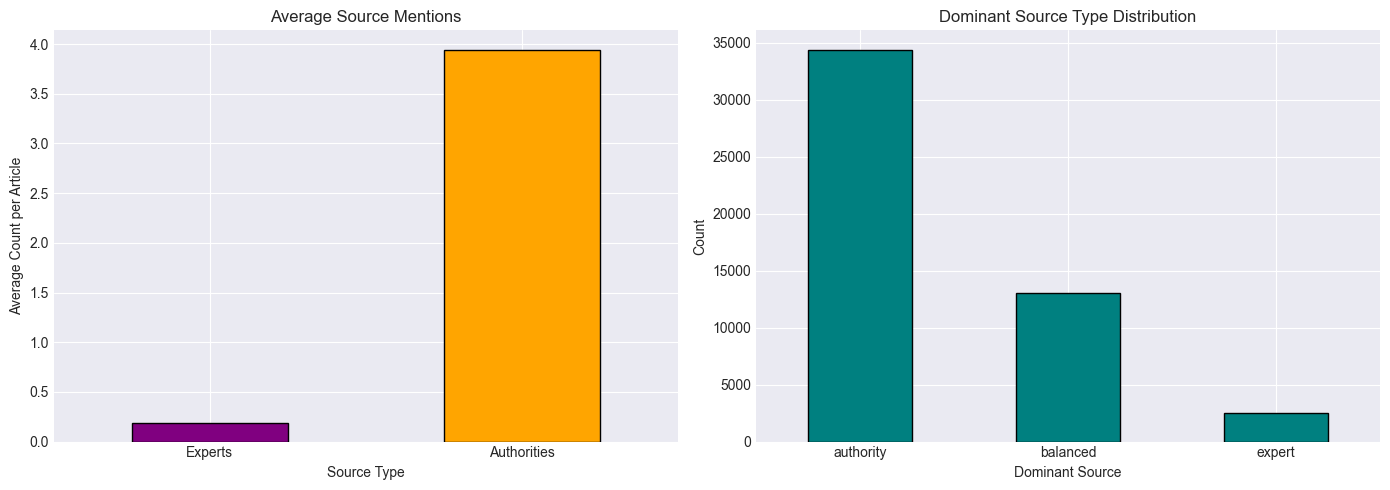

In [17]:
# Visualize sources
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Source counts
source_data = pd.DataFrame({
    'Experts': df['expert_mention_count'],
    'Authorities': df['authority_mention_count']
})
source_data.mean().plot(kind='bar', ax=axes[0], color=['purple', 'orange'], edgecolor='black')
axes[0].set_xlabel('Source Type')
axes[0].set_ylabel('Average Count per Article')
axes[0].set_title('Average Source Mentions')
axes[0].tick_params(axis='x', rotation=0)

# Dominant source
df['dominant_source'].value_counts().plot(kind='bar', ax=axes[1],
                                          color='teal', edgecolor='black')
axes[1].set_xlabel('Dominant Source')
axes[1].set_ylabel('Count')
axes[1].set_title('Dominant Source Type Distribution')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

#### Key Insights: Source Types in Coverage

1) Authority figures dominate sourcing, appearing on average nearly 4 times per article, while expert voices are mentioned only a fraction as often, indicating a strong preference for official/authority sources.

2) Most articles are authority‑centric, with the dominant source type being authorities in the majority of pieces, a smaller share showing balanced use of authorities and experts, and only a small minority being primarily expert‑driven.

 ## 8. Representation Patterns

In [18]:
print("\nAnalyzing representation patterns...")

# Demographic mention patterns (from keyword features if available)
DEMOGRAPHIC_TERMS = {
    'gender_male': ['man', 'men', 'male', 'he', 'his', 'him'],
    'gender_female': ['woman', 'women', 'female', 'she', 'her'],
    'age_young': ['youth', 'young', 'student'],
    'age_old': ['elderly', 'senior', 'old']
}

for category, terms in DEMOGRAPHIC_TERMS.items():
    df[f'{category}_representation'] = df['text_for_analysis'].apply(
        lambda x: count_role_terms(x, terms)
    )

# Gender representation balance
df['gender_representation_balance'] = (
    df['gender_male_representation'] - df['gender_female_representation']
) / (df['gender_male_representation'] + df['gender_female_representation'] + 1)

# Age representation balance
df['age_representation_balance'] = (
    df['age_young_representation'] - df['age_old_representation']
) / (df['age_young_representation'] + df['age_old_representation'] + 1)

print("Representation analysis complete")


Analyzing representation patterns...
Representation analysis complete


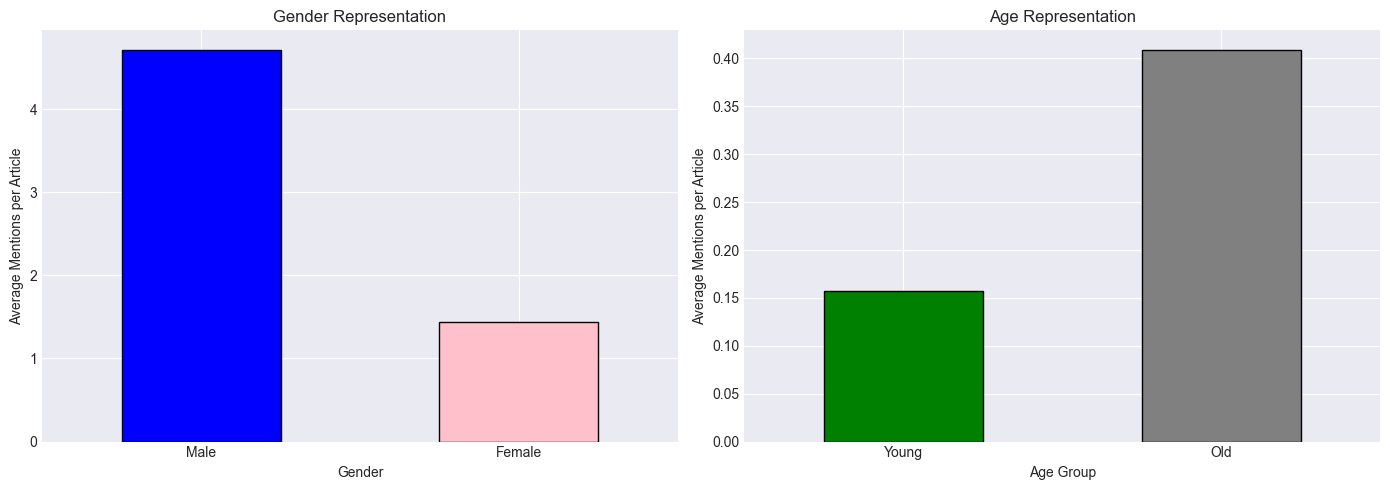

In [19]:
# Visualize representation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender representation
gender_data = pd.DataFrame({
    'Male': df['gender_male_representation'],
    'Female': df['gender_female_representation']
})
gender_data.mean().plot(kind='bar', ax=axes[0], color=['blue', 'pink'], edgecolor='black')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Average Mentions per Article')
axes[0].set_title('Gender Representation')
axes[0].tick_params(axis='x', rotation=0)

# Age representation
age_data = pd.DataFrame({
    'Young': df['age_young_representation'],
    'Old': df['age_old_representation']
})
age_data.mean().plot(kind='bar', ax=axes[1], color=['green', 'gray'], edgecolor='black')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Average Mentions per Article')
axes[1].set_title('Age Representation')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

#### Key Insights: Gender and Age Representation

1) Men are referenced far more often than women, with male mentions per article roughly three times higher than female mentions, indicating a strong gender visibility gap.

2) Older people receive more coverage than younger people, with “old” mentions more than twice those of “young,” suggesting an age skew toward older groups in the articles.

 ## 9. Feature Summary

In [20]:
# List all discourse features
discourse_features = [
    # Voice
    'passive_voice_count', 'passive_voice_ratio', 'high_passive_voice',

    # Agency
    'agent_deletion_count', 'agent_deletion_ratio', 'agentless_count',

    # Quotes
    'quote_count', 'attribution_count', 'said_count',
    'quote_ratio', 'attribution_ratio',

    # Roles
    'decision_maker_count', 'victim_count',
    'decision_maker_ratio', 'victim_ratio', 'dominant_role',

    # Framing
    'protagonist_count', 'antagonist_count',
    'framing_balance', 'dominant_framing',

    # Sources
    'expert_mention_count', 'authority_mention_count',
    'expert_authority_ratio', 'dominant_source',

    # Representation
    'gender_male_representation', 'gender_female_representation',
    'gender_representation_balance',
    'age_young_representation', 'age_old_representation',
    'age_representation_balance'
]

print(f"\n=== DISCOURSE FEATURES SUMMARY ===")
print(f"Total discourse features: {len(discourse_features)}")
print(f"\nFeature categories:")
print(f"  - Voice analysis: 3")
print(f"  - Agency: 3")
print(f"  - Quote attribution: 5")
print(f"  - Role analysis: 5")
print(f"  - Framing: 4")
print(f"  - Source attribution: 4")
print(f"  - Representation: 6")


=== DISCOURSE FEATURES SUMMARY ===
Total discourse features: 30

Feature categories:
  - Voice analysis: 3
  - Agency: 3
  - Quote attribution: 5
  - Role analysis: 5
  - Framing: 4
  - Source attribution: 4
  - Representation: 6


 ## 10. Save Features

In [21]:
# Select columns to save
columns_to_save = ['url'] + discourse_features

df_discourse = df[columns_to_save].copy()

print(f"\nSaving discourse features...")
df_discourse.to_parquet(OUTPUT_FILE, index=False, compression='snappy')

print(f"Saved to: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Rows: {len(df_discourse):,}")
print(f"  Features: {len(discourse_features)}")


Saving discourse features...
Saved to: ../data/processed/discourse_features.parquet
  Size: 3.55 MB
  Rows: 49,926
  Features: 30


 ## 11. Summary Report

In [22]:
print("=" * 60)
print("DISCOURSE & REPRESENTATION FEATURES SUMMARY")
print("=" * 60)
print(f"\nINPUT: {len(df):,} articles")
print(f"OUTPUT: {len(discourse_features)} discourse features")
print(f"\nFEATURE BREAKDOWN:")
print(f"  Active/passive voice detection")
print(f"  Agency and agent deletion analysis")
print(f"  Quote attribution patterns")
print(f"  Decision-maker vs victim roles")
print(f"  Protagonist/antagonist framing")
print(f"  Expert vs authority attribution")
print(f"  Demographic representation balance")
print(f"\nKEY INSIGHTS:")
print(f"  - High passive voice: {df['high_passive_voice'].sum():,} articles ({df['high_passive_voice'].mean() * 100:.1f}%)")
print(f"  - Articles with quotes: {(df['quote_count'] > 0).sum():,} ({(df['quote_count'] > 0).mean() * 100:.1f}%)")
print(f"  - Dominant framing: {df['dominant_framing'].value_counts().to_dict()}")
print(f"  - Dominant source: {df['dominant_source'].value_counts().to_dict()}")
print(f"\nOUTPUT FILE:")
print(f"  {OUTPUT_FILE}")
print("\n" + "=" * 60)
print("Notebook 6 Complete!")
print("=" * 60)

DISCOURSE & REPRESENTATION FEATURES SUMMARY

INPUT: 49,926 articles
OUTPUT: 30 discourse features

FEATURE BREAKDOWN:
  Active/passive voice detection
  Agency and agent deletion analysis
  Quote attribution patterns
  Decision-maker vs victim roles
  Protagonist/antagonist framing
  Expert vs authority attribution
  Demographic representation balance

KEY INSIGHTS:
  - High passive voice: 9,763 articles (19.6%)
  - Articles with quotes: 7,661 (15.3%)
  - Dominant framing: {'neutral': 25807, 'negative': 13083, 'positive': 11036}
  - Dominant source: {'authority': 34383, 'balanced': 13072, 'expert': 2471}

OUTPUT FILE:
  ../data/processed/discourse_features.parquet

Notebook 6 Complete!
